# Rhyming score experiments

This notebook is for rhyming score experiments. HAMR 2016.

In [1]:
from __future__ import print_function, unicode_literals
import string

import nltk
import numpy

# For plotting outputs, we'll need
import matplotlib.pyplot as plt
# To display the plotted images inside the notebook:
%matplotlib inline
# Plotting the figures at a reasonable size
import matplotlib
matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)

# Dirty, dirty trick
import rhyme
reload(rhyme)
from rhyme import *

In [2]:
cmudict = collections.defaultdict(list)
for word, syl in nltk.corpus.cmudict.entries():
    cmudict[word].append(syl)

In [3]:
bad_text = 'I see all I know all For i am the the oracle Give me your hand' \
    ' I see caked blood on concrete Dead bodies on grass' \
    ' Mothers crying seeing babies lowered caskets'
# bad_text = 'this thing does not rhyme even a little it is just normal text no rap'

good_text = 'Yeah, yeah It\'s the return of the Wild Style fashionist' \
' Smashin hits, make it hard to adapt to this Put pizazz and jazz in this, and cash in this' \
' Mastered this, flash this and make em clap to this DJ\'s throw on cuts and obey the crowd' \
' Just pump the volume up, and play it loud'
# good_text = 'take a step back hey really gonna hack a full stack in a day while on crack'

In [4]:
bad_words = tokenize(bad_text)
good_words = tokenize(good_text)

In [5]:
def pairwise_grid_stats(score_grid, words):
    minimum = score_grid[score_grid != -1.0].min()
    maximum = score_grid.max()
    print('Range: {0} -- {1}'.format(minimum, maximum))

def pairwise_rhyme_visualization(score_grid, words, show=True):

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(score_grid, cmap=plt.cm.Blues)

    ax.set_xlim((0, len(words)))
    ax.set_ylim((0, len(words)))
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(numpy.arange(score_grid.shape[0])+0.5, minor=False)
    ax.set_yticks(numpy.arange(score_grid.shape[1])+0.5, minor=False)

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    ax.set_xticklabels(words, minor=False)
    ax.set_yticklabels(words, minor=False)

    if show:
        plt.show()



In [6]:
def score_words(words, prondict=cmudict):
    score_grid = rhyme_score_grid(words, prondict=prondict)
    aggregate = aggregate_score(score_grid)
    return aggregate

def score_and_visualize_words(words, prondict=cmudict):
    score_grid = rhyme_score_grid(words, prondict=prondict)
    score = aggregate_score(score_grid)
    print('Score: {0:.4f}'.format(score))
    stats = pairwise_grid_stats(score_grid, words)
    pairwise_rhyme_visualization(score_grid, words)

In [7]:
#score_and_visualize_words(bad_words)

In [8]:
#score_and_visualize_words(good_words)

### Assessing the metric: baseline

To get some understanding of how this metric works, we need to find a baseline. Let's use some random sequences from the Brown corpus.

Obvious limit of the metric: at some point, we will randomly get a rhyming word anyway. Tackled by a sliding window of max. 16 words.

In [9]:
bt_reader = nltk.corpus.brown.words()
brown_tokens = [t for i, t in enumerate(bt_reader) if i < 10000]

In [17]:
bad_text_max_length = 50
n_bad_texts = 100
bad_texts = []
for i in xrange(n_bad_texts):
    # Choose a random start
    start = numpy.random.randint(low=0, high=len(brown_tokens) - bad_text_max_length - 1)
    text = brown_tokens[start:start + bad_text_max_length]
    bad_texts.append(' '.join(text))

In [18]:
bad_text_words = [tokenize(t) for t in bad_texts]
bad_text_scores = numpy.array([score_words(w) for w in bad_text_words[:100]])


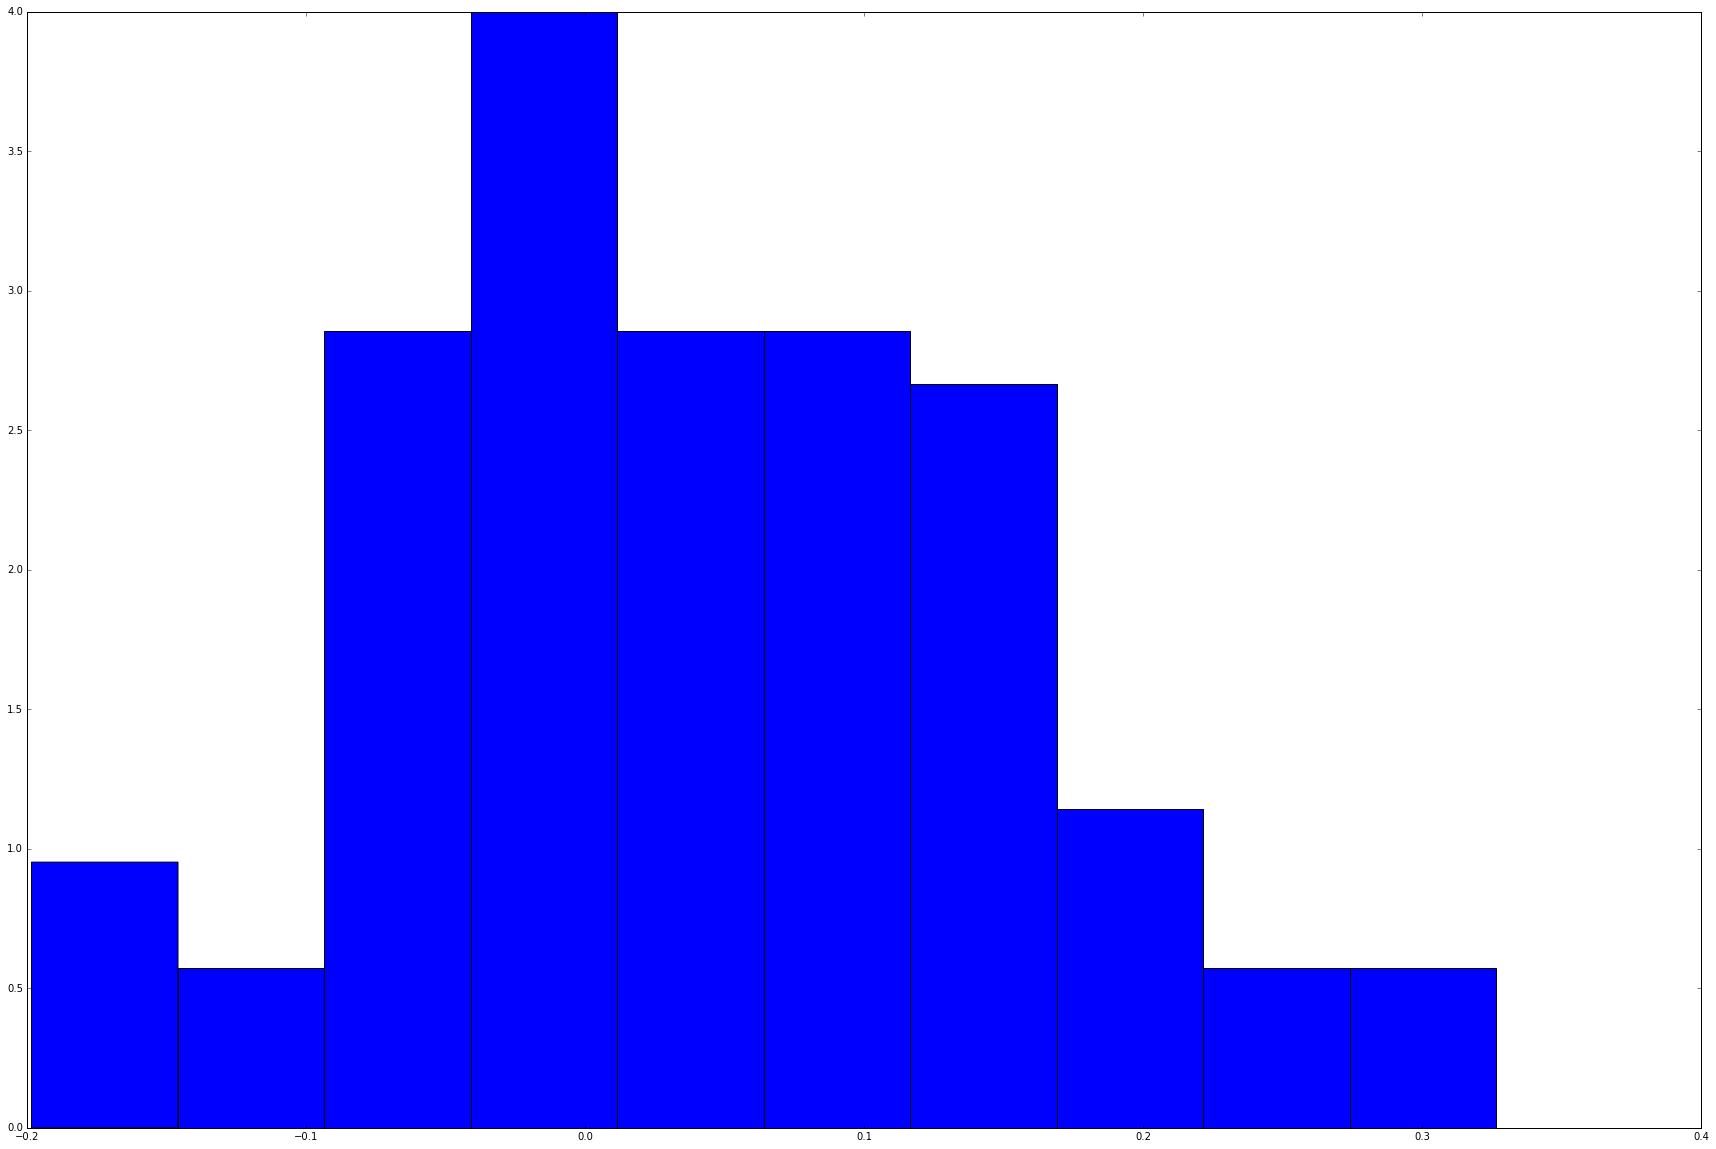

In [28]:
n, bins, patches = plt.hist(bad_text_scores, 10, normed=True)
plt.show()

In [25]:
import codecs

def parse_artist(filename):
    with codecs.open(filename, 'r', 'utf-8') as hdl:
        lines = [l.strip() for l in hdl]
    
    texts = []
    current_text = []
    for l in lines:
        if len(l) == 0:
            texts.append(' '.join(current_text))
            current_text = []
        else:
            current_text.append(l)
    if len(current_text) > 0:
        texts.append(' '.join(current_text))
    
    return texts

rakim_texts = parse_artist('examples_good_rhymes/rakim')
eminem_texts = parse_artist('examples_good_rhymes/eminem')
aesop_texts = parse_artist('examples_good_rhymes/aesop_rock')
lilwayne_texts = parse_artist('examples_good_rhymes/lil_wayne')

In [30]:
good_texts = list(itertools.chain(rakim_texts, eminem_texts, aesop_texts, lilwayne_texts))
# print(len(good_texts))
good_words = [tokenize(t) for t in good_texts]
good_text_scores = [score_words(w[:30]) for w in good_words]

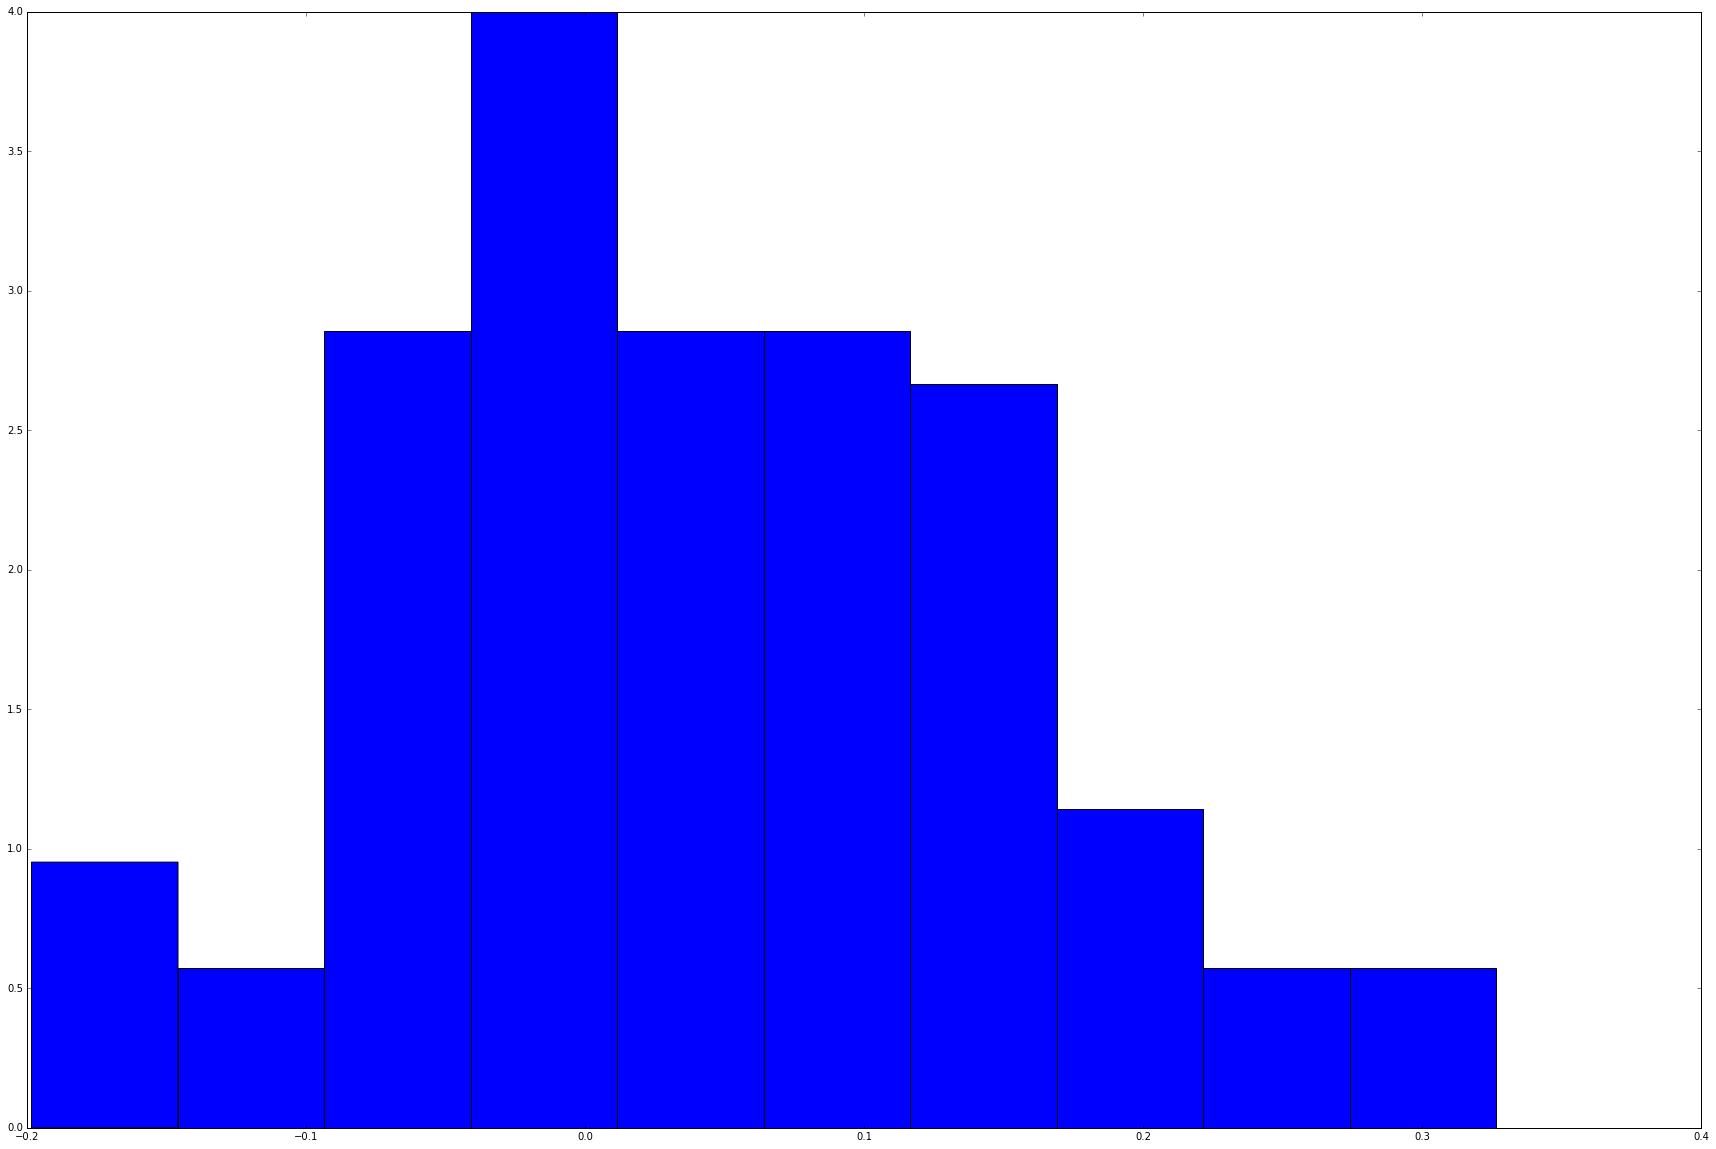

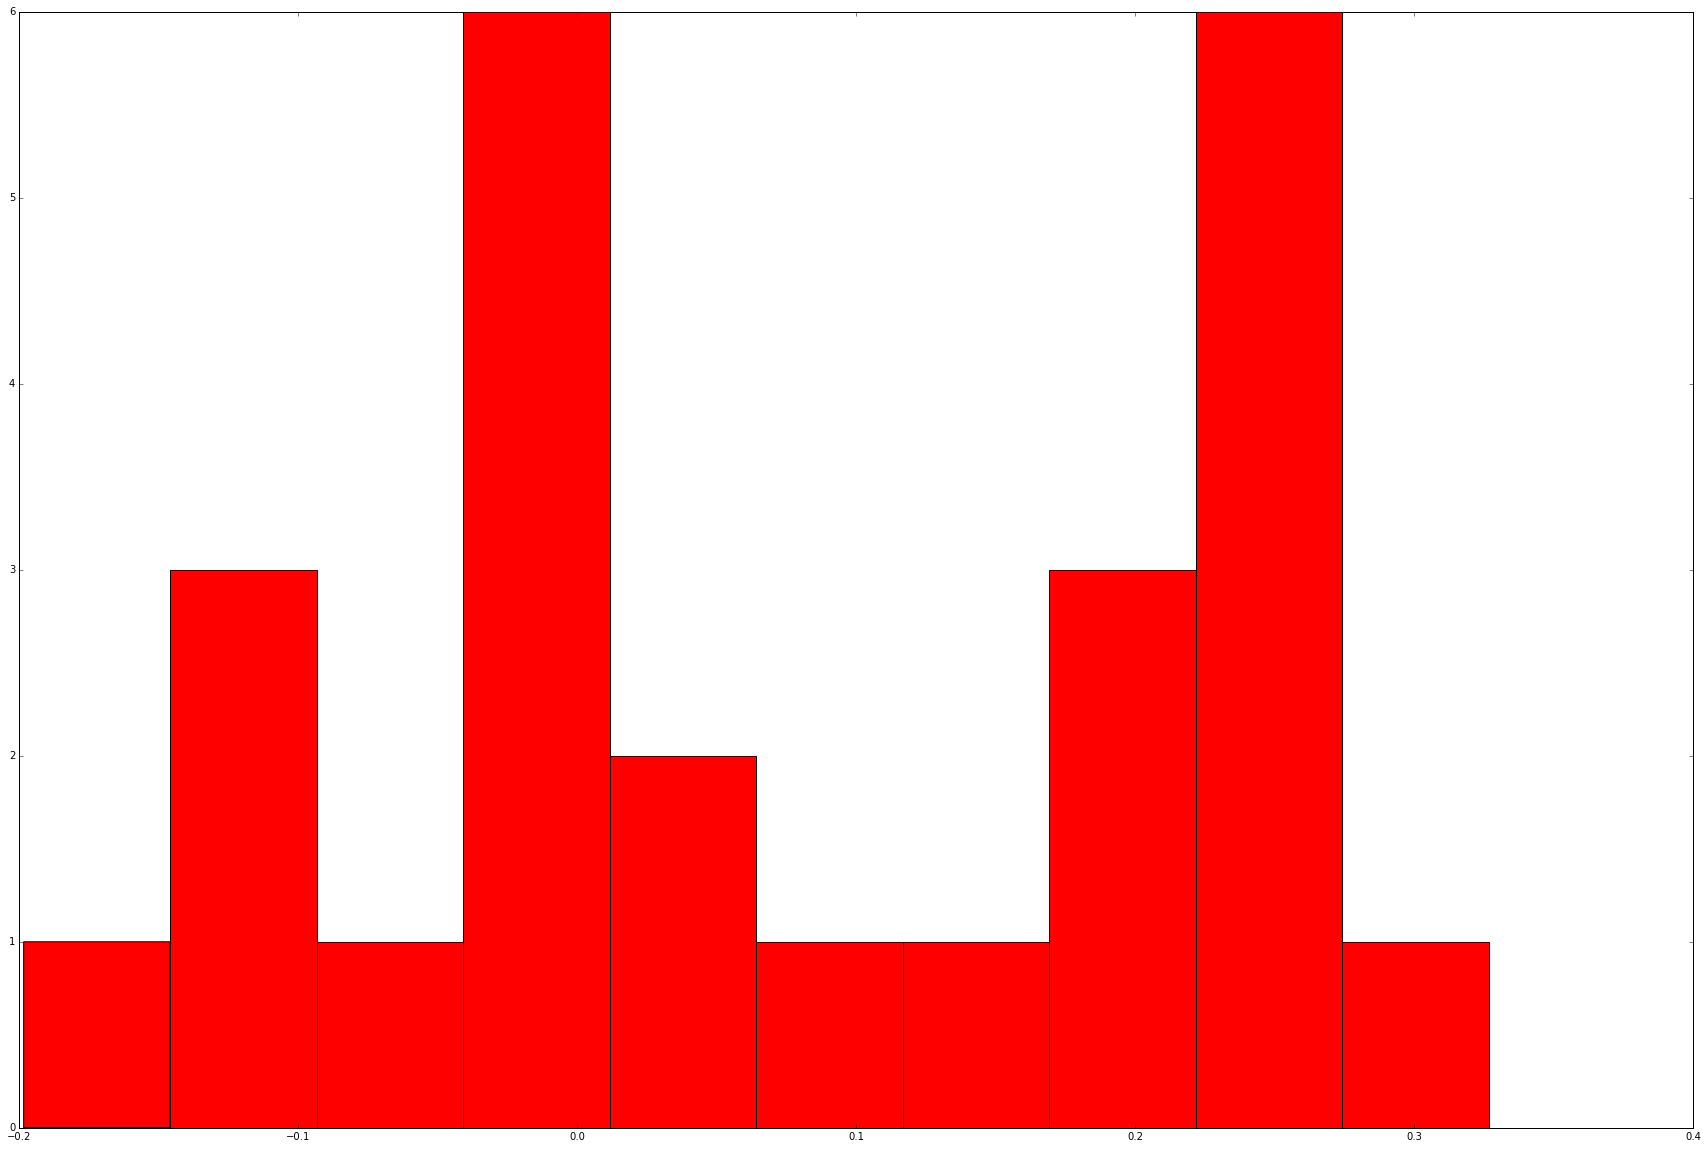

In [34]:
n, bins, patches = plt.hist(bad_text_scores, 10, normed=True)
plt.show()
_, _, _ = plt.hist(good_text_scores, bins=bins, color='r')
plt.show()

### Ideas on improving

* Disambiguate the indefinite article.
* Remove stopwords (count them as -1). Implemented as "weak" stopwords (if the other word is not a weak stopword, count normally) vs. "strong" (if one of the words is a strong stopword, the pair gets -1)
* Only count words within a relevant window (improves on randomness)
* Only retain nouns, verbs, adjectives and adverbs. (NOT IMPLEMENTED)
* Word count patterns: 